In [1]:
import tinyarray as ta
import numpy as np
import matplotlib.pyplot as plt
import importlib
import json
import kwant

from codes.gate_design import gate_coords
from codes.constants import scale, bands, topological_gap
import codes.trijunction as trijunction
import codes.optimization as optimization
import codes.parameters as parameters
from codes.tools import hamiltonian
from codes.utils import eigsh, svd_transformation, dict_update, dep_acc_index
from codes.utils import order_wavefunctions, ratio_Gaussian_curvature

VoronoiMesh version 0.1
DiscretePoisson version 0.3
Shape version: 0.1
SystEquations version: 0.3
Solver version 0.1


In [2]:
from scipy.optimize import minimize, minimize_scalar

In [3]:
with open('/home/tinkerer/trijunction-design/codes/config.json', 'r') as f:
    config = json.load(f)

change_config = [
    {"device": {"thickness": {"dielectric": 0.5}}},
    {"gate": {"channel_width": 11.0, 'angle': np.pi/6, 'gap': 1}},
]

for local_config in change_config:
    config = dict_update(config, local_config)

In [4]:
system = trijunction.Trijunction(config, optimize_phase_pairs=[])

Finding closed voronoi cells
Done selecting closed voronoi cells
Calculating points distance
Done
Calculating ridges hypersurfaces
Done
Finding  hypervolume for closed voronoi cells
Done finding hypervolume for closed voronoi cells
Done calculating surface
Done calculating distance
Done calculating capacitance matrix


100%|██████████| 13/13 [00:33<00:00,  2.58s/it]


### Initial voltage guess

In [5]:
import codes.gate_design
import importlib
importlib.reload(codes.gate_design)

<module 'codes.gate_design' from '/home/tinkerer/trijunction-design/analysis/codes/gate_design.py'>

In [7]:
kwant_sites = np.array([site.pos for site in system.trijunction.sites])

In [8]:
L = config['gate']['L']
gap = config['gate']['gap']
shift = 1
spacing = (config["device"]["grid_spacing"]["twoDEG"]*scale)/1e-9
npts = np.rint(
    (L + gap + (spacing - gap % spacing) - (shift*spacing))/spacing).astype(int)

indices = codes.utils.dep_acc_index(
    zip(system.gate_names, system.gates_vertex), 
    system.nw_centers, 
    kwant_sites, 
    np.pi/6, 
    a=10e-9, 
    shift=shift, 
    spacing=spacing, 
    npts=npts
)

[[-18.    4.5]
 [-15.5   8.5]
 [-13.   13. ]
 [-10.5  17.5]
 [ -8.   21.5]
 [ -5.5  26. ]
 [ -3.   30.5]
 [ -0.5  34.5]]
[[18.   4.5]
 [15.5  8.5]
 [13.  13. ]
 [10.5 17.5]
 [ 8.  21.5]
 [ 5.5 26. ]
 [ 3.  30.5]
 [ 0.5 34.5]]
[[ 0. 72.]
 [ 0. 67.]
 [ 0. 62.]
 [ 0. 57.]
 [ 0. 52.]
 [ 0. 47.]
 [ 0. 42.]
 [ 0. 37.]]
[[-19.5  24. ]]
[[-5.   8.5]]
[[5.  8.5]]
[[19.5 24. ]]
[[-16.  57.]]
[[16. 57.]]


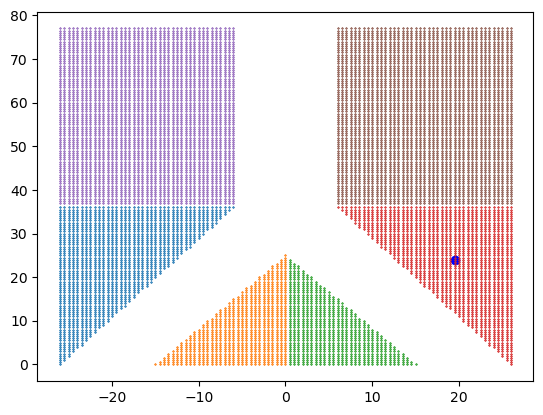

In [198]:
site_coords = system.grid_points[system.site_indices]
for gate, index in system.indices.items():
    point = kwant_sites[index]/scale
    if gate=='right_2': plt.scatter(point[:, 0], point[:, 1], c='b')
    print(point)


for key, value in system.poisson_system.regions.voltage.tag_points.items():
    if not key.startswith(('global', 'dirichlet')):
        coords = system.grid_points[value] 

        plt.scatter(coords[:, 0], coords[:, 1], s = 0.1)

#### Optimize potential shape

In [176]:
import codes.optimization
importlib.reload(codes.optimization)

<module 'codes.optimization' from '/home/tinkerer/trijunction-design/analysis/codes/optimization.py'>

In [ ]:
optimal_voltages = {}
optimal_phase = {}
for pair in ['left-top']:
    
    params = parameters.junction_parameters()
    params.update(potential=system.flat_potential())
    params['dep_acc_index'] = indices

    args = (pair.split('-'),
            (system.base_ham, system.linear_terms),
            params['dep_acc_index'], 
            )

    initial_condition = (-3e-3, -3e-3, -3e-3, 3e-3)

    sol1 = minimize(codes.optimization.shape_loss, 
             x0=initial_condition, 
             args=args, 
             method='trust-constr', 
             options={'initial_tr_radius':1e-3}
            )

    print(sol1.x)

    ci, wf_amp = 50, 1e-4
    args = ((system.base_ham, 
            params, 
            system.linear_terms, 
            system.f_params, 
             system.mlwf[order_wavefunctions(pair)]),
            (pair.split('-'), params['dep_acc_index'], (ci, wf_amp))
           )

    sol2 = minimize(codes.optimization.wavefunction_loss, 
             x0=sol1.x, 
             args=args, 
             method='trust-constr',
             options={
                 'initial_tr_radius':1e-3,
                 'verbose':2,
             }
            )

    print(sol2.x)

    params.update(parameters.voltage_dict(sol2.x))
    
    args = (pair, 
            params, 
            (system.trijunction, system.linear_terms, 
             system.f_params,
             system.mlwf[order_wavefunctions(pair)]
            )
           )

    sol3 = minimize_scalar(codes.optimization.loss, 
                             args=args, 
                             method='bounded', 
                             bounds=(0,2)
                          )

    
    optimal_phase[pair] = sol3.x * np.pi
    
    print(optimal_phase[pair])

    params.update(parameters.phase_pairs(pair, optimal_phase[pair]))
    params.update(potential=system.flat_potential())
    params['dep_acc_index'] = indices
    
    base_ham = system.trijunction.hamiltonian_submatrix(
        sparse=True, params=system.f_params(**params)
    )

    args = (pair, 
            params, 
            (base_ham, system.linear_terms, 
             system.f_params,
             system.mlwf[order_wavefunctions(pair)]
            ),
           )
    
    file = '/home/tinkerer/trijunction-design/codes/coupling.json'
    with open(file, 'w') as outfile:
        json.dump({}, outfile)

    sol4 = minimize(codes.optimization.loss, 
             x0=sol2.x, 
             args=args, 
             method='trust-constr', 
             options={
                 'initial_tr_radius':1e-3,
                 'verbose':2,
             }
            )
    
    optimal_voltages[pair] = parameters.voltage_dict(sol4.x)
    
    file = '/home/tinkerer/trijunction-design/codes/coupling.json'
    with open(file, 'w') as outfile:
        json.dump({}, outfile)
        
    
    print(optimal_voltages[pair])

[-0.00295426 -0.00415171 -0.00314533  0.00278515]
4.782915199915396e-17
4.78370853979368e-17
4.783139854780135e-17
4.78352537555271e-17
4.783129943935273e-17
| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   5   |   0   | +2.2625e-05 | 1.00e-03 | 3.53e-02 | 0.00e+00 |
|   2   |  10   |   1   | +9.1854e-09 | 2.00e-03 | 2.77e-02 | 0.00e+00 |
1.7487844634905116e-14
1.7486766657823427e-14
1.748778478040254e-14
1.7486640149600086e-14
1.748813598744758e-14
|   3   |  15   |   3   | -4.7977e-05 | 1.07e-02 | 8.15e-02 | 0.00e+00 |
|   4   |  20   |   5   | -1.2616e-04 | 1.33e-02 | 1.62e+00 | 0.00e+00 |
6.34348297074477e-06
6.342463319783473e-06
6.343512076986934e-06
6.341842909402711e-06
6.343376506037793e-06
|   5   |  25   |   6   | -1.0000e+00 | 9.30e-02 | 0.00e+00 | 0.00e+00 |

`gtol` termination condition is satisfied.
Number of iterations: 5, function evaluations: 25, CG iterations:

#### Results

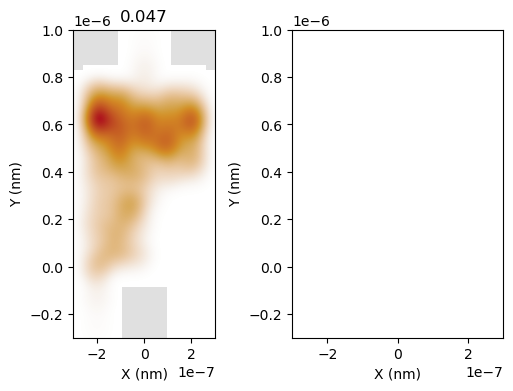

In [247]:
fig, ax = plt.subplots(ncols=2, figsize=(6, 4))

for i, pair in enumerate(['left-top']):
    params = parameters.junction_parameters()
    params.update(potential=system.flat_potential())
    params.update(parameters.voltage_dict([0.00445208, -0.00677312,  0.00246512,  0.00417225]))
    
    base_ham = system.trijunction.hamiltonian_submatrix(
        sparse=True, params=system.f_params(**params)
    )

    linear_ham, full_ham = hamiltonian(base_ham, 
                                       system.linear_terms, 
                                       **params
                                      )

    

    evals, evecs = eigsh(full_ham, k=6, sigma=0, return_eigenvectors=True)

    transformed_hamiltonian = svd_transformation(
        evals, evecs, system.mlwf[order_wavefunctions(pair)]
    )

    desired = np.abs(transformed_hamiltonian[0, 1])
    undesired = np.linalg.norm(transformed_hamiltonian[2:])
    
    wfv = system.densityoperator(evecs[:, 0])
    
    # potential = linear_ham.diagonal()[::4]
    # step_potential = np.array(np.abs(potential) > bands[0], dtype=int)
    # kwant.plotter.map(system.trijunction, lambda i: step_potential[i], ax=ax[0])
    kwant.plotter.density(system.trijunction, wfv, ax = ax[i]);
    ax[i].set_title(np.round(desired/topological_gap, 3))
    # for value in system.indices.values():
    #     ax[0].scatter(*kwant_sites[value], c='blue')
    
    # voltages = list(optimal_voltages[pair].values())
    # print(pair + ':', np.array(voltages)[list(range(0, 7, 2))])
for axes in ax:
    axes.set_ylim(-3e-7, 10e-7)
    axes.set_xlim(-3e-7, 3e-7)
    axes.set_xlabel('X (nm)')
    axes.set_ylabel('Y (nm)')
    
# fig.tight_layout()
# plt.savefig('/home/tinkerer/trijunction-design/codes/wavefunction.pdf', format='pdf')

#### Wavefunction loss

In [264]:
import codes.optimization
importlib.reload(codes.optimization)

<module 'codes.optimization' from '/home/tinkerer/trijunction-design/analysis/codes/optimization.py'>

In [ ]:
params = parameters.junction_parameters()
params.update(potential=system.flat_potential())
params['dep_acc_index'] = indices
    
ci, wf_amp = 50, 1e-4
args = ((system.base_ham, 
        params, 
        system.linear_terms, 
        system.f_params, 
         system.mlwf[order_wavefunctions(pair)]),
        (pair.split('-'), params['dep_acc_index'], (ci, wf_amp))
       )

sol2 = minimize(codes.optimization.wavefunction_loss, 
         x0=sol1.x, 
         args=args, 
         method='trust-constr',
         options={
             'initial_tr_radius':1e-3,
             'verbose':2,
         }
        )

In [265]:
params = parameters.junction_parameters()
params.update(potential=system.flat_potential())
params['dep_acc_index'] = indices

args = (pair,
        params,
       (system.base_ham, 
        system.linear_terms, 
        system.f_params, 
        system.mlwf[order_wavefunctions(pair)]),
       )


sol2 = minimize(codes.optimization.loss, 
         x0=x0, 
         args=args, 
         method='trust-constr',
         options={'initial_tr_radius':1e-3,
                  'verbose':2,
                 }
        )

[-0.00295426 -0.00415171 -0.00314533  0.00278515  0.1       ]
[-0.00295426 -0.00415171 -0.00314533  0.00278515  0.1       ]
1.504930836352882e-13 0.00025627833539455065
[1.26523529e-05 1.35697196e-05] 4.792970039421423e-06 0.9323960466313989 [[ 5041592.81467227 10007233.87865024]
 [   19930.18776071 10060754.05871032]]
[-0.00295428 -0.00415171 -0.00314533  0.00278515  0.1       ]
1.5045891085562972e-13 0.00025627837500971987
[1.26521708e-05 1.35697183e-05] 4.792967370380588e-06 0.9323827115323351 [[ 5041842.4338462  10007236.10998888]
 [   19930.77213159 10060755.63273409]]
[-0.00295426 -0.00415173 -0.00314533  0.00278515  0.1       ]
1.5055193675081711e-13 0.0002562791939720358
[1.26523447e-05 1.35697184e-05] 4.792915884832528e-06 0.9323955291253897 [[ 5041601.09415148 10007235.4055975 ]
 [   19930.22190874 10060756.26016323]]
[-0.00295426 -0.00415171 -0.00314535  0.00278515  0.1       ]
1.5047227076515209e-13 0.000256278351738925
[1.26523496e-05 1.35695069e-05] 4.792969045130187e-06 

KeyboardInterrupt: 